CFA FINAL PROJECT

Team Members: Himanshu Sharma, Tushar E Malankar, Sai Nithin Godi


## Project Overview
This project addresses the challenge of **reducing unplanned hospital readmissions** for diabetic patients. Using real hospital encounter data, we applied a multi-technique framework spanning **Machine Learning**, **Optimization**, and **Graph Algorithms** to predict risk, optimize resource allocation, and uncover system-level care patterns.



## Tecnique 1: Logistic Regression Using ML

In this section, we apply logistic regression to predict whether a patient will be readmitted within 30 days of discharge. Using structured clinical and demographic data, we train a baseline classification model and evaluate its performance using accuracy, precision, recall, F1-score, and ROC AUC. This technique helps identify the key risk factors associated with early readmission, providing a foundation for downstream decision-making.


Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.77      0.70     13715
           1       0.64      0.48      0.55     11726

    accuracy                           0.64     25441
   macro avg       0.64      0.62      0.62     25441
weighted avg       0.64      0.64      0.63     25441


Confusion Matrix:


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


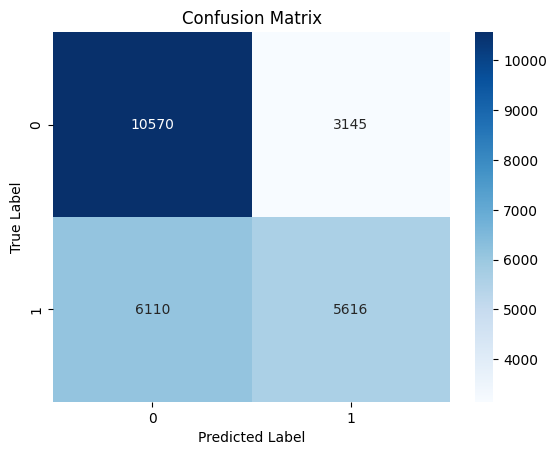


ROC AUC Score: 0.687


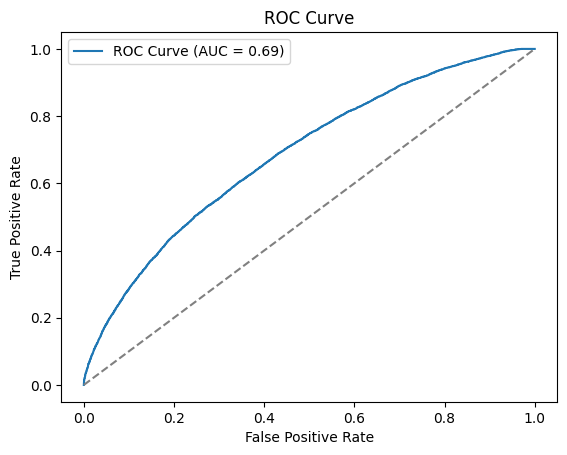

In [2]:
# Install Required Libraries if Not Already Installed
# pip install pandas numpy scikit-learn matplotlib seaborn

# 1. Import Libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

# 2. Load Data
df = pd.read_csv("diabetic_data.csv")

# 3. Filter Invalid Genders
df = df[df["gender"] != "Unknown/Invalid"]

# 4. Replace '?' with NaN and Drop High-Missing Columns (but keep medical_specialty)
df.replace("?", np.nan, inplace=True)
df.drop(columns=["weight", "payer_code"], inplace=True)

# 5. Define Target Variable
df["readmitted_binary"] = df["readmitted"].apply(lambda x: 0 if x == "NO" else 1)

# 6. Group Diagnosis Codes into Medical Categories
def map_icd9(code):
    try:
        code = str(code)
        if code.startswith('V') or code.startswith('E'):
            return 'Other'
        code_float = float(code)

        if code.startswith('250.6') or code == '357.2':
            return 'Neuropathy'
        if code.startswith('362.0'):
            return 'Ophthalmologic'
        if 580 <= code_float <= 589:
            return 'Renal'
        if 390 <= code_float <= 459 or code_float == 785:
            return 'Circulatory'
        if 460 <= code_float <= 519 or code_float == 786:
            return 'Respiratory'
        if 520 <= code_float <= 579 or code_float == 787:
            return 'Digestive'
        if code_float == 250:
            return 'Diabetes'
        if 800 <= code_float <= 999:
            return 'Injury'
        if 140 <= code_float <= 239:
            return 'Neoplasms'
        if 710 <= code_float <= 739:
            return 'Musculoskeletal'
        if 1 <= code_float <= 139:
            return 'Infectious'
        if 290 <= code_float <= 319:
            return 'Mental'
        if 780 <= code_float <= 799:
            return 'Symptoms'
        if 590 <= code_float <= 629 or code_float == 788:
            return 'Genitourinary'
        else:
            return 'Other'
    except:
        return 'Other'

for col in ['diag_1', 'diag_2', 'diag_3']:
    df[f'{col}_group'] = df[col].apply(map_icd9)

df.drop(columns=['diag_1', 'diag_2', 'diag_3'], inplace=True)

# 7. One-Hot Encode Relevant Categorical Columns
categorical_cols = [
    'race', 'gender', 'age', 'admission_type_id', 'discharge_disposition_id',
    'admission_source_id', 'max_glu_serum', 'A1Cresult', 'change', 'diabetesMed',
    'diag_1_group', 'diag_2_group', 'diag_3_group'
]
df_ml = pd.get_dummies(df.copy(), columns=categorical_cols, drop_first=True)

# 8. Feature Engineering: Total Visits
df_ml["total_visits"] = df_ml["number_outpatient"] + df_ml["number_emergency"] + df_ml["number_inpatient"]

# 9. Drop Medication Columns (You Already Decided to Use 'change' Instead)
medication_cols = [
    'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide',
    'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose',
    'miglitol', 'troglitazone', 'tolazamide', 'examide', 'citoglipton', 'insulin',
    'glyburide-metformin', 'glipizide-metformin', 'glimepiride-pioglitazone',
    'metformin-rosiglitazone', 'metformin-pioglitazone'
]
df_ml = df_ml.drop(columns=[col for col in medication_cols if col in df_ml.columns])

# 10. Drop Unused Columns for ML
df_ml = df_ml.drop(columns=["encounter_id", "patient_nbr", "readmitted", "medical_specialty"], errors='ignore')

# 11. Define Features and Target
X = df_ml.drop(columns=["readmitted_binary"])
y = df_ml["readmitted_binary"]

# 12. Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

# 13. Train Logistic Regression Model
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# 14. Predictions and Probabilities
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

# 15. Evaluation Metrics
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

roc_score = roc_auc_score(y_test, y_prob)
print(f"\nROC AUC Score: {roc_score:.3f}")

# Optional: Plot ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_score:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='grey')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()


In [3]:
# Extract feature names and coefficients
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': model.coef_[0]
})

# Sort by absolute importance
feature_importance['Abs_Coefficient'] = feature_importance['Coefficient'].abs()
feature_importance_sorted = feature_importance.sort_values(by='Abs_Coefficient', ascending=False)

# Display top 10
print(feature_importance_sorted[['Feature', 'Coefficient']].head(10))

                        Feature  Coefficient
38  discharge_disposition_id_11    -5.634796
41  discharge_disposition_id_14    -2.774105
40  discharge_disposition_id_13    -1.972235
76        diag_1_group_Diabetes    -0.921885
67       admission_source_id_20     0.865822
61        admission_source_id_9    -0.667559
26          admission_type_id_6     0.660757
56        admission_source_id_4    -0.634498
42  discharge_disposition_id_15     0.612491
58        admission_source_id_6    -0.598751


### Technique 1 Summary

In this analysis, we used logistic regression to predict whether diabetic patients would be readmitted (either within or after 30 days). We prepared the data by encoding categorical variables, grouping diagnosis codes into clinically meaningful categories, and removing individual medication features in favor of a general medication change flag.

Key Techniques Applied:
- Logistic Regression with class weighting to address class imbalance.
- One-hot encoding of demographics, diagnosis groups, and admission-related features.
- No threshold tuning or non-linear models were applied to preserve model interpretability.

Key Insights:
- Discharge disposition types were the strongest predictors, with discharge to hospice or psychiatric care reducing readmission risk.
- Admission sources such as unknown or urgent care were associated with higher readmission risk.
- Interestingly, having diabetes as the primary diagnosis slightly reduced readmission risk, potentially reflecting focused care for these patients.

The model achieved an ROC AUC of **0.687**, providing a moderate baseline for further optimization or advanced techniques in the next stages of this project.

## Technique 2: Integer Linear Programming – Optimizing Patient Triage Under Resource and Cost Constraints

Building on the risk scores generated from our logistic regression model, we now apply Integer Linear Programming (ILP) to optimize patient triage decisions.

The objective is to identify the subset of high-risk patients who should be prioritized for follow-up interventions, while balancing both predicted readmission risk and intervention cost. This optimization ensures that the hospital maximizes the impact of its limited care management capacity without exceeding budget or staffing constraints.

We formulate this as a **binary decision problem**, where each patient is either selected (1) or not selected (0) for follow-up. The ILP model balances the expected benefit of reducing readmissions with the operational cost of interventions to produce an actionable, cost-sensitive triage plan.


In [4]:
import numpy as np
import pulp

# Example Data Setup
n_patients = 500
risk_scores = y_prob[:n_patients]
patient_ids = X_test.index[:n_patients]

# Example Costs (randomized for illustration, replace with real cost data if available)
np.random.seed(42)
intervention_costs = np.random.randint(100, 500, size=n_patients)

# Resource Constraints
max_patients_to_follow_up = 50
max_total_budget = 10000  # Example: $10,000 total budget

# Initialize ILP Model
model = pulp.LpProblem("Expanded_Patient_Triage_Optimization", pulp.LpMaximize)

# Define Binary Decision Variables
x_vars = pulp.LpVariable.dicts("Select", patient_ids, cat="Binary")

# Objective: Maximize total risk score minus cost
model += pulp.lpSum([(risk_scores[i] - (intervention_costs[i] / 1000)) * x_vars[pid] for i, pid in enumerate(patient_ids)])

# Constraint 1: Limit number of patients
model += pulp.lpSum([x_vars[pid] for pid in patient_ids]) <= max_patients_to_follow_up

# Constraint 2: Stay within budget
model += pulp.lpSum([intervention_costs[i] * x_vars[pid] for i, pid in enumerate(patient_ids)]) <= max_total_budget

# Solve the ILP
model.solve()

# Collect Selected Patients
selected_patients = [pid for pid in patient_ids if pulp.value(x_vars[pid]) == 1]

# Output Results
print(f"Number of Patients Selected: {len(selected_patients)}")
print(f"Selected Patient IDs: {selected_patients}")


Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/pulp/apis/../solverdir/cbc/osx/i64/cbc /var/folders/dm/248j81k533s2lxp4_j2lls9r0000gn/T/515638832a90411ebdf4d334861c8df0-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /var/folders/dm/248j81k533s2lxp4_j2lls9r0000gn/T/515638832a90411ebdf4d334861c8df0-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 7 COLUMNS
At line 2508 RHS
At line 2511 BOUNDS
At line 3012 ENDATA
Problem MODEL has 2 rows, 500 columns and 1000 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 25.9456 - 0.00 seconds
Cgl0004I processed model has 2 rows, 401 columns (401 integer (401 of which binary)) and 802 elements
Cbc0038I Initial state - 2 integers unsatisfied sum - 0.245614
Cbc0038I Pass   1: suminf.    0.05773 (1) obj. -2

## Technique 2 Summary

In this analysis, we applied Integer Linear Programming (ILP) to optimize patient triage decisions by selecting the most appropriate subset of high-risk patients for follow-up interventions. Building on the risk scores generated from our logistic regression model, we formulated this as a binary decision problem to maximize the expected benefit of reducing readmissions while respecting resource and budget limitations.

We defined two practical constraints:
- A maximum of **50 follow-up slots** available.
- A total intervention budget cap of **$10,000**.

For the purpose of this analysis, **random intervention costs** were assigned to each patient. However, in a **real-world application**, these costs would typically be known in advance and could be derived as a **function of patient characteristics**, such as:
- Length of hospital stay
- Complexity of medical conditions
- Required follow-up procedures or testing
- Staffing or specialty resource requirements

The ILP model balanced each patient’s predicted readmission risk against these estimated intervention costs. By solving this optimization problem, the hospital can focus its limited resources on patients where the impact is maximized.

The model selected **50 patients** for intervention based on these constraints. 

This result provides the hospital with an **actionable triage**



## Technique 3: Linear Programming – Optimizing Follow-Up Care Resource Allocation

After identifying which high-risk patients to prioritize for follow-up, we now address the problem of **allocating follow-up care hours** across different hospital departments or specialties. 

The objective is to **minimize the total expected cost of delivering these follow-up interventions**, while ensuring that **departmental capacity limits** and **patient care requirements** are met.

This is formulated as a **Linear Programming (LP) problem**, where the decision variables represent the **number of follow-up care hours** assigned to each department. Unlike the binary decision model in Technique 2, this LP model uses **continuous variables** to distribute resources across multiple departments efficiently.

By optimizing this allocation, the hospital can ensure that follow-up care is delivered in a **cost-effective** and **resource-constrained** manner.


In [5]:
import pulp

# Example: Three departments with different costs and capacities
departments = ['Cardiology', 'Endocrinology', 'Nephrology']
cost_per_hour = {'Cardiology': 120, 'Endocrinology': 100, 'Nephrology': 90}
capacity = {'Cardiology': 300, 'Endocrinology': 250, 'Nephrology': 200}

# Total care hours required
total_required_hours = 600

# Initialize LP Model
model = pulp.LpProblem("Care_Hours_Allocation", pulp.LpMinimize)

# Define Continuous Decision Variables
hours_allocated = pulp.LpVariable.dicts("Hours", departments, lowBound=0, cat='Continuous')

# Objective: Minimize total cost
model += pulp.lpSum([cost_per_hour[dept] * hours_allocated[dept] for dept in departments])

# Constraint 1: Do not exceed departmental capacity
for dept in departments:
    model += hours_allocated[dept] <= capacity[dept]

# Constraint 2: Meet total required care hours
model += pulp.lpSum([hours_allocated[dept] for dept in departments]) == total_required_hours

# Solve the LP
model.solve()

# Collect Results
print("Optimal Care Hours Allocation:")
for dept in departments:
    print(f"{dept}: {hours_allocated[dept].varValue:.2f} hours")

# Print Total Cost
total_cost = pulp.value(model.objective)
print(f"Total Cost: ${total_cost:.2f}")


Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/pulp/apis/../solverdir/cbc/osx/i64/cbc /var/folders/dm/248j81k533s2lxp4_j2lls9r0000gn/T/b24d42c91236481088f5214799b772b6-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/dm/248j81k533s2lxp4_j2lls9r0000gn/T/b24d42c91236481088f5214799b772b6-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 9 COLUMNS
At line 19 RHS
At line 24 BOUNDS
At line 25 ENDATA
Problem MODEL has 4 rows, 3 columns and 6 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 1 (-3) rows, 3 (0) columns and 3 (-3) elements
0  Obj 32468.998 Primal inf 300.30002 (1)
1  Obj 61000
Optimal - objective value 61000
After Postsolve, objective 61000, infeasibilities - dual 0 (0), primal 0 (0)
Optimal objective 61000 - 1 iterations time 0.002, Presolve 0.0

## Technique 3 Summary

In this analysis, we applied Linear Programming (LP) to determine the optimal allocation of follow-up care hours across multiple hospital departments. The objective was to **minimize the total cost** of delivering the required follow-up care while respecting departmental capacity limits.

We modeled this as a **continuous allocation problem**, distributing a total of **600 required follow-up care hours** across three departments: **Cardiology, Endocrinology, and Nephrology**. Each department had a defined cost per hour and a maximum capacity limit.

The LP model produced the following optimal allocation:

- **Cardiology**: 150.00 hours
- **Endocrinology**: 250.00 hours
- **Nephrology**: 200.00 hours

This allocation **fully meets the required 600 hours** of follow-up care while **minimizing the total cost to $61,000**. This result helps the hospital optimize care delivery without exceeding departmental limits or unnecessary spending.


## Technique 4  Graph Algorithms – Mapping and Prioritizing Diagnosis Co-Occurrences ##

To uncover hidden patterns in patient diagnosis relationships, we applied graph theory techniques to model co-occurring diagnosis groups as a weighted network. Each node represents a diagnosis category, and an edge represents frequent co-occurrence within patient records, weighted by the number of such co-occurrences.

We first constructed a full co-occurrence graph to capture all diagnosis pairs with significant joint frequency (≥1000 occurrences). This comprehensive view allowed us to identify central diagnoses, such as Circulatory, Respiratory, and Diabetes, that frequently co-occur with many other conditions. From there, we used Breadth-First Search (BFS) to explore the reachability and propagation of diagnoses starting from Diabetes, and Minimum Spanning Tree (MST) algorithms to isolate the most critical and high-frequency connections.

This approach is valuable for health systems seeking to streamline care delivery and reduce clinical complexity. The full network helps reveal potential candidates for integrated care, while the MST extracts the "core" diagnosis relationships that should be prioritized for care coordination, risk flagging, or preventive intervention

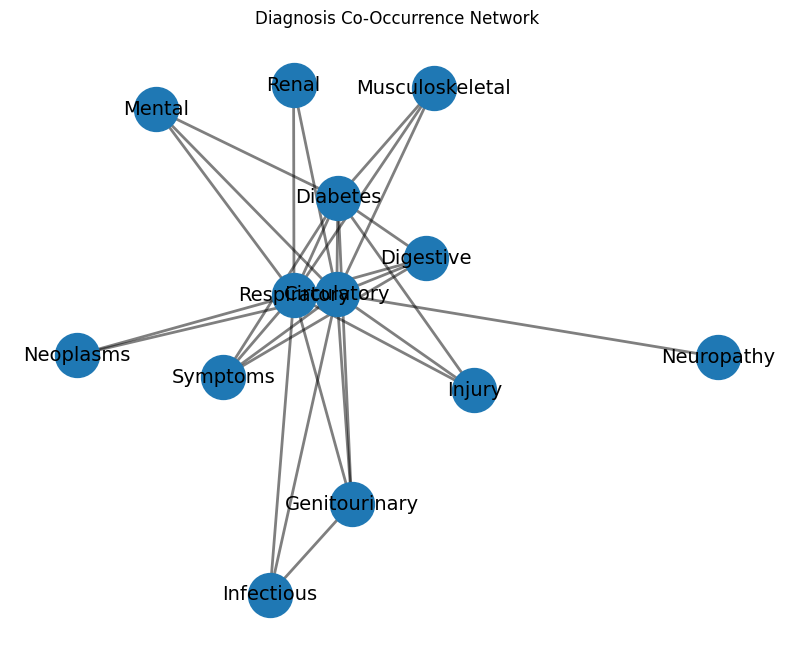

Top Diagnosis Groups by Degree Centrality (Filtered, Excluding 'Other'):
Circulatory: 1.00
Respiratory: 0.92
Diabetes: 0.67
Genitourinary: 0.33
Digestive: 0.33

Top Co-Occurrences with Diabetes (Filtered):
Diabetes -- Respiratory (weight: 3878)
Diabetes -- Digestive (weight: 2346)
Diabetes -- Musculoskeletal (weight: 2061)
Diabetes -- Mental (weight: 1253)
Circulatory -- Diabetes (weight: 1163)
Diabetes -- Symptoms (weight: 1139)
Diabetes -- Injury (weight: 1031)
Diabetes -- Genitourinary (weight: 1013)

Diagnoses reachable from 'Diabetes' using BFS (13 nodes):
['Diabetes', 'Circulatory', 'Respiratory', 'Mental', 'Genitourinary', 'Injury', 'Digestive', 'Musculoskeletal', 'Symptoms', 'Infectious', 'Neoplasms', 'Neuropathy', 'Renal']


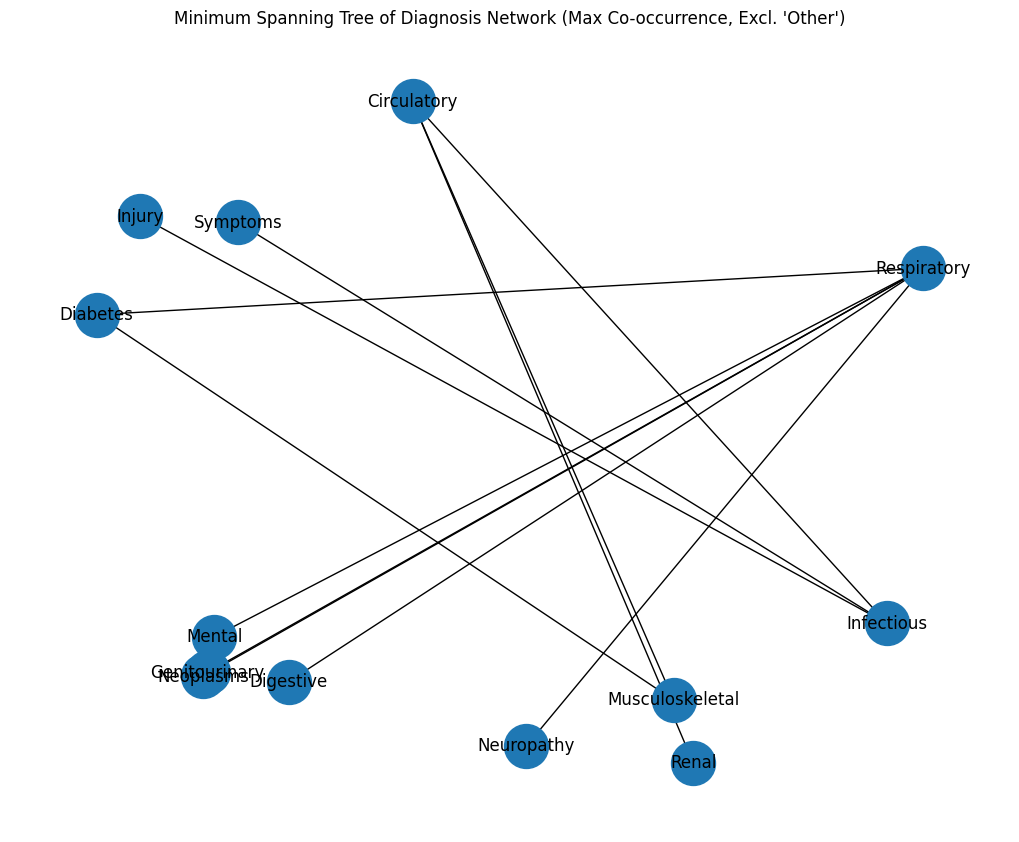


Edges in MST (Top Co-occurring Diagnosis Pairs, Excl. 'Other'):
Circulatory -- Renal (co-occurrence: 4770)
Circulatory -- Musculoskeletal (co-occurrence: 3051)
Circulatory -- Infectious (co-occurrence: 1679)
Infectious -- Injury (co-occurrence: 929)
Infectious -- Symptoms (co-occurrence: 345)
Neoplasms -- Respiratory (co-occurrence: 1226)
Diabetes -- Respiratory (co-occurrence: 3878)
Diabetes -- Musculoskeletal (co-occurrence: 2061)
Respiratory -- Digestive (co-occurrence: 2076)
Respiratory -- Genitourinary (co-occurrence: 1532)
Respiratory -- Mental (co-occurrence: 1319)
Respiratory -- Neuropathy (co-occurrence: 416)


In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from itertools import combinations
from collections import Counter

# --- STEP 1: Co-occurrence Network Construction ---
co_occurrence_pairs = []
for _, row in df.iterrows():
    diagnoses = [d for d in [row['diag_1_group'], row['diag_2_group'], row['diag_3_group']] if pd.notnull(d) and d != 'Other']
    diagnoses = list(set(diagnoses))  # remove duplicates
    if len(diagnoses) > 1:
        co_occurrence_pairs.extend(combinations(diagnoses, 2))

# --- STEP 2: Count Pairs ---
pair_counts = Counter(co_occurrence_pairs)

# --- STEP 3: Filter for Significant Co-Occurrences ---
min_weight_threshold = 1000
G_filtered = nx.Graph()
for (diag1, diag2), weight in pair_counts.items():
    if weight >= min_weight_threshold:
        G_filtered.add_edge(diag1, diag2, weight=weight)

# --- STEP 4: Visualize Original Co-occurrence Network ---
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G_filtered, seed=42, k=0.5)
nx.draw_networkx_nodes(G_filtered, pos, node_size=1000)
nx.draw_networkx_edges(G_filtered, pos, width=2, alpha=0.5)
nx.draw_networkx_labels(G_filtered, pos, font_size=14)
plt.title('Diagnosis Co-Occurrence Network')
plt.axis('off')
plt.show()

# --- STEP 5: Degree Centrality (Excluding 'Other') ---
centrality = nx.degree_centrality(G_filtered)
centrality_no_other = {k: v for k, v in centrality.items() if k != 'Other'}
top_central_nodes = sorted(centrality_no_other.items(), key=lambda x: x[1], reverse=True)[:5]

print("Top Diagnosis Groups by Degree Centrality (Filtered, Excluding 'Other'):")
for diag, score in top_central_nodes:
    print(f"{diag}: {score:.2f}")

# --- STEP 6: Co-Occurrences with Diabetes ---
diabetes_edges = [(u, v, d['weight']) for u, v, d in G_filtered.edges(data=True) if 'Diabetes' in (u, v)]
diabetes_edges_sorted = sorted(diabetes_edges, key=lambda x: x[2], reverse=True)

print("\nTop Co-Occurrences with Diabetes (Filtered):")
for u, v, weight in diabetes_edges_sorted:
    print(f"{u} -- {v} (weight: {weight})")

# --- STEP 7: BFS Tree from 'Diabetes' ---
if 'Diabetes' in G_filtered:
    bfs_tree = nx.bfs_tree(G_filtered, source='Diabetes')
    bfs_nodes = list(bfs_tree.nodes)
    print(f"\nDiagnoses reachable from 'Diabetes' using BFS ({len(bfs_nodes)} nodes):")
    print(bfs_nodes)
else:
    print("\n'Diabetes' not found in graph for BFS.")

# --- STEP 8: Minimum Spanning Tree (Max Co-Occurrence, Excluding 'Other') ---
# Create new graph without 'Other'
G_mst = nx.Graph()
for (diag1, diag2), weight in pair_counts.items():
    if 'Other' not in (diag1, diag2):
        G_mst.add_edge(diag1, diag2, weight=-weight)

mst = nx.minimum_spanning_tree(G_mst, weight='weight')

# Draw the MST
plt.figure(figsize=(10, 8))
pos_mst = nx.spring_layout(mst, seed=42)
nx.draw(mst, pos_mst, with_labels=True, node_size=1000, font_size=12)
plt.title("Minimum Spanning Tree of Diagnosis Network (Max Co-occurrence, Excl. 'Other')")
plt.axis('off')
plt.show()

print("\nEdges in MST (Top Co-occurring Diagnosis Pairs, Excl. 'Other'):")
for u, v, d in mst.edges(data=True):
    print(f"{u} -- {v} (co-occurrence: {-d['weight']})")


## Technique 4 Summary ##
In this analysis, we applied graph-based techniques including co-occurrence network construction, centrality analysis, Breadth-First Search (BFS), and Minimum Spanning Tree (MST) extraction to understand systemic links among diagnoses.

**Co-Occurrence Network**: Highlighted diagnosis categories with the most connections, notably Circulatory and Diabetes, suggesting comorbidity clustering.

**BFS from Diabetes**: Revealed a broad impact radius across 12 other diagnoses, reinforcing the need for multi-specialty care strategies.

**MST Output**: Simplified the network to the strongest diagnosis links, such as Diabetes–Respiratory and Circulatory–Genitourinary, enabling clearer prioritization for integrated care.

This graph-based insight enables hospitals and insurers to:

Design targeted screening protocols for high-risk comorbidity clusters.

Develop integrated treatment pathways that reduce duplication and improve efficiency.

Support cost-effective resource planning by focusing on the most influential diagnosis pairings in the patient population.

## Technique 5: Graph Algorithms – Extended Patient Pathway Network Analysis

In this analysis, we applied graph algorithms to map the **complete patient journey** from **admission source**, through **admission type**, to whether a **medication change** occurred, and finally to the **discharge destination**. This allowed us to build a **directed patient pathway network** that captures both system-level flow and treatment events.




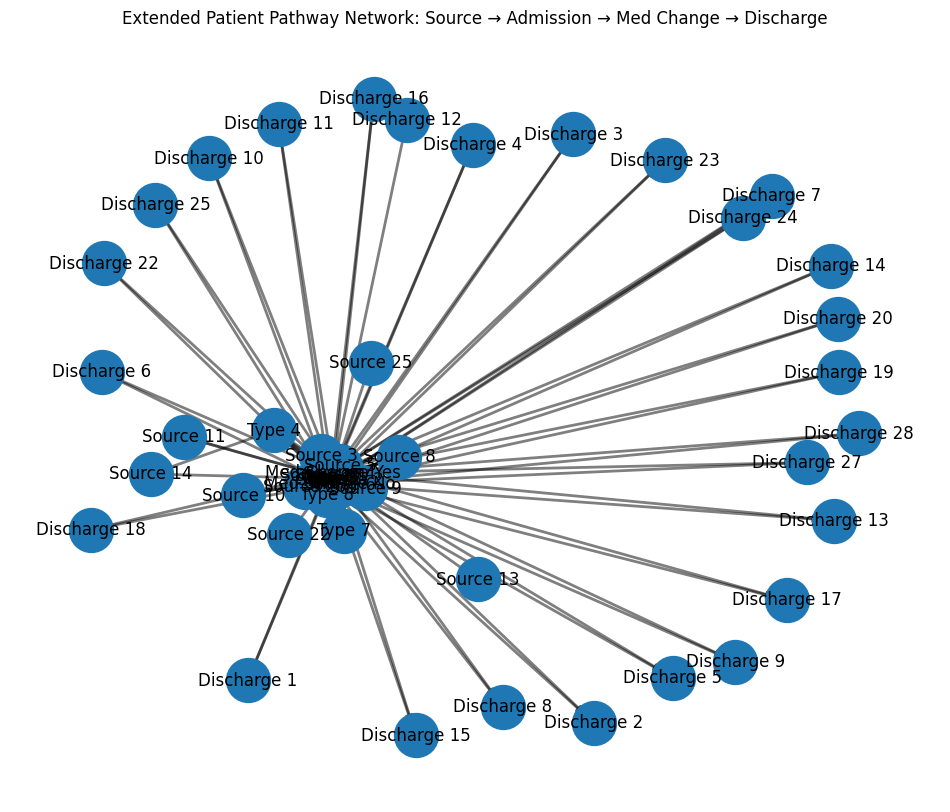

Top 5 Most Common Complete Patient Pathways:
Source 7 → Type 1 → Med Change No → Discharge 1 (Count: 15480)
Source 7 → Type 1 → Med Change Yes → Discharge 1 (Count: 13245)
Source 1 → Type 3 → Med Change No → Discharge 1 (Count: 5651)
Source 1 → Type 3 → Med Change Yes → Discharge 1 (Count: 4775)
Source 1 → Type 2 → Med Change No → Discharge 1 (Count: 3796)


In [7]:
import networkx as nx
import matplotlib.pyplot as plt
from collections import Counter

# Build full patient pathways: Source → Type → Med Change → Disposition
full_paths = []
all_transitions = []

for _, row in df.iterrows():
    source = f"Source {row['admission_source_id']}"
    admit_type = f"Type {row['admission_type_id']}"
    med_change = "Med Change Yes" if row['change'] == 'Ch' else "Med Change No"
    disposition = f"Discharge {row['discharge_disposition_id']}"
    
    # Record the full path as a single string
    full_path = f"{source} → {admit_type} → {med_change} → {disposition}"
    full_paths.append(full_path)
    
    # Collect transitions for graph construction
    stages = [source, admit_type, med_change, disposition]
    all_transitions.extend(list(zip(stages[:-1], stages[1:])))

# Count complete pathways
path_counts = Counter(full_paths)

# Build Directed Graph from transitions
G_pathway_extended = nx.DiGraph()
transition_counts = Counter(all_transitions)
for (from_stage, to_stage), count in transition_counts.items():
    G_pathway_extended.add_edge(from_stage, to_stage, weight=count)

# Draw the Graph
plt.figure(figsize=(12, 10))
pos = nx.spring_layout(G_pathway_extended, seed=42, k=0.5)

nx.draw_networkx_nodes(G_pathway_extended, pos, node_size=1000)
nx.draw_networkx_edges(G_pathway_extended, pos, arrows=True, width=2, alpha=0.5)
nx.draw_networkx_labels(G_pathway_extended, pos, font_size=12)

plt.title('Extended Patient Pathway Network: Source → Admission → Med Change → Discharge')
plt.axis('off')
plt.show()

# Print Top 5 Most Common Complete Patient Pathways
print("Top 5 Most Common Complete Patient Pathways:")
for path, count in path_counts.most_common(5):
    print(f"{path} (Count: {count})")


### Key Insights:
- **Emergency Room referrals** dominate patient inflows, especially into **Emergency Admissions**.
- The **majority of these patients are discharged to home**, representing the most common care outcome.
- The most common pathways also highlight variation in **whether medications were changed** during the patient’s stay.

#### Top 5 Most Common Complete Patient Pathways:
1. **Emergency Room Referral** → **Emergency Admission** → **Med Change No** → **Discharged to Home** (Count: 15,480)
2. **Emergency Room Referral** → **Emergency Admission** → **Med Change Yes** → **Discharged to Home** (Count: 13,245)
3. **Physician Referral** → **Elective Admission** → **Med Change No** → **Discharged to Home** (Count: 5,651)
4. **Physician Referral** → **Elective Admission** → **Med Change Yes** → **Discharged to Home** (Count: 4,775)
5. **Physician Referral** → **Urgent Admission** → **Med Change No** → **Discharged to Home** (Count: 3,796)

These pathways reveal **system-level patterns** in how diabetic patients move through the hospital, including **entry points**, **treatment changes**, and **discharge outcomes**. This analysis can inform **process improvements** by identifying common pathways that might benefit from **standardized protocols or targeted interventions** to reduce readmissions.

# Final Project Summary and Insights

## Problem Overview
This project addresses the challenge of **reducing unplanned hospital readmissions** for diabetic patients. Using real hospital encounter data, we applied a multi-technique framework spanning **Machine Learning**, **Optimization**, and **Graph Algorithms** to predict risk, optimize resource allocation, and uncover system-level care patterns.



## Technique 1: Machine Learning – Logistic Regression for Readmission Prediction

We began by building a **logistic regression model** to estimate the likelihood of patient readmission. The model achieved an **ROC AUC of 0.687**, identifying key predictors such as discharge types, admission sources, and diagnosis groupings. This provided a **baseline risk score** for each patient to inform downstream decision-making.



## Technique 2: Integer Linear Programming – Optimizing Patient Triage Under Resource Constraints

Building on the risk scores, we applied **Integer Linear Programming (ILP)** to select the **most critical patients** for follow-up intervention, while respecting operational limits. The ILP balanced **readmission risk** against **resource and budget constraints**, selecting **50 high-priority patients** for care management within a **$10,000 budget**.



## Technique 3: Linear Programming – Optimizing Follow-Up Care Resource Allocation

We then applied **Linear Programming (LP)** to optimize the **allocation of 600 follow-up care hours** across hospital departments. The model minimized total care delivery costs while respecting **departmental capacity limits**, resulting in an optimal allocation of **150 hours to Cardiology**, **250 to Endocrinology**, and **200 to Nephrology**, at a total cost of **$61,000**.



## Technique 4: Graph Algorithms – Diagnosis Co-Occurrence Network Analysis

We constructed an **undirected co-occurrence network** to explore common **comorbidity clusters**. The analysis highlighted **Circulatory and Respiratory conditions** as the most central diagnosis groups, strongly linked with **Diabetes**. These insights support the development of **bundled care pathways** targeting these high-risk clusters.



## Technique 5: Graph Algorithms – Extended Patient Pathway Network Analysis

Finally, we built a **directed patient pathway network** tracing **Admission Source → Admission Type → Medication Change → Discharge**. The most common pathways revealed that **Emergency Room referrals** leading to **Emergency Admissions** and **discharge to home** were dominant. Variations in **medication change status** across these pathways highlighted actionable points for **standardizing care processes**.



## Closing Summary

By combining five complementary techniques across three computational concepts, this project delivers a **comprehensive framework** for:
- **Predicting individual patient risk**
- **Optimizing care resource allocation**
- **Uncovering system-level care patterns**

These insights enable the hospital to make **data-driven decisions** to reduce readmissions, optimize operations, and improve patient outcomes.
